In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
from utils import load_config, load_manifold_data
from manifold_learning.generate_manifolds import ManifoldLearning
from alphashape import alphashape
from pycpd import RigidRegistration

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Generate embedding data

In [2]:
# Load config
config = load_config("/Users/damian_gerber/Library/Mobile Documents/com~apple~CloudDocs/01 - Master Mathematics/MIT/Thesis/thesis_dgerber/config.yaml")

# Load data
distance_matrix = np.load("/Users/damian_gerber/Library/Mobile Documents/com~apple~CloudDocs/01 - Master Mathematics/MIT/Thesis/thesis_dgerber/src/data/graph_data/D_mat.npy")

# Parameters
k = config["manifold"]["n_neighbors"]  # Reduced k value
n_components = config["manifold"]["n_components"]  # Number of components

manifold_learning = ManifoldLearning(distance_matrix, k, n_components)
embeddings = manifold_learning.apply_kernel_pca()

In [3]:


def visualize_manifold_from_numpy(points):
    """Visualizes a 3D manifold, handling coplanar data and enabling interactivity.

    Args:
        points: NumPy array of shape (n_points, 3).
    """

    if points.shape[0] < 4:
        print("Not enough points to form a 3D triangulation.")
        return

    try:
        tri = Delaunay(points)
        triangles = tri.simplices

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles=triangles, cmap=plt.cm.Spectral, alpha=0.7, edgecolor='k', linewidth=0.2)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Manifold Visualization')

        plt.show()  # Crucial: Show before interactive mode
        plt.ion()
        plt.pause(0.001)

    except Exception as e:
        print(f"An error occurred: {e}")

def filter_triangles(points, triangles, max_aspect_ratio=10, min_area = 0.001):
    filtered_triangles = []
    for triangle_indices in triangles:
        p1 = points[triangle_indices[0]]
        p2 = points[triangle_indices[1]]
        p3 = points[triangle_indices[2]]

        # Calculate side lengths
        a = np.linalg.norm(p2 - p1)
        b = np.linalg.norm(p3 - p2)
        c = np.linalg.norm(p1 - p3)

        # Calculate area (Heron's formula)
        s = (a + b + c) / 2
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))

        # Calculate aspect ratio
        sides = sorted([a, b, c])
        if sides[0] == 0:
            aspect_ratio = float('inf')
        else:
            aspect_ratio = sides[2] / sides[0]  # Longest / shortest

        if area > min_area and aspect_ratio <= max_aspect_ratio:
            filtered_triangles.append(triangle_indices)
    return np.array(filtered_triangles)

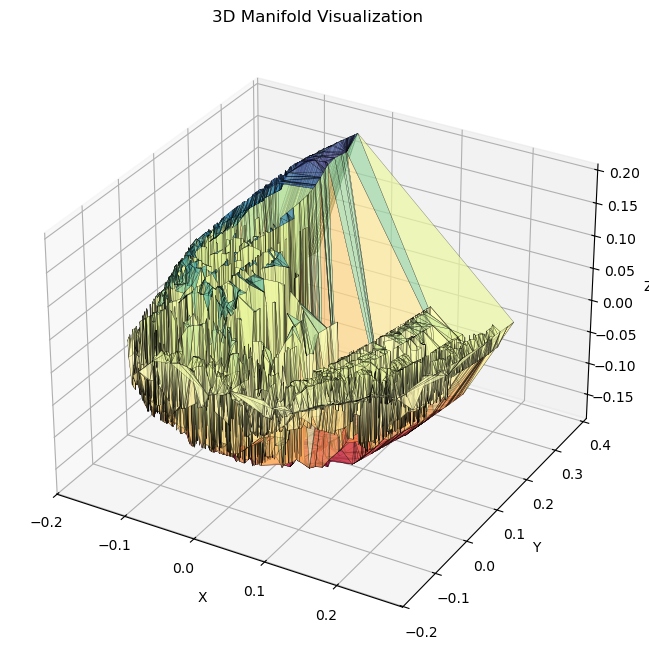

In [4]:
visualize_manifold_from_numpy(embeddings)

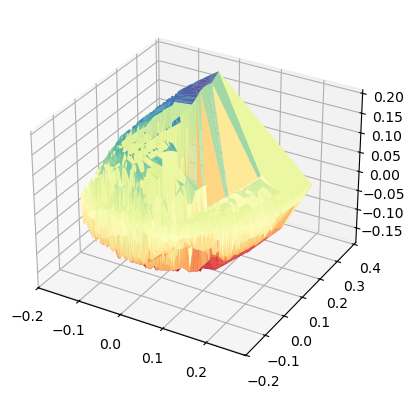

In [5]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tri = Delaunay(embeddings)


filtered_triangles = filter_triangles(embeddings, tri.simplices, max_aspect_ratio=0.0001, min_area=1)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], triangles=filtered_triangles, cmap=plt.cm.Spectral)
plt.show()

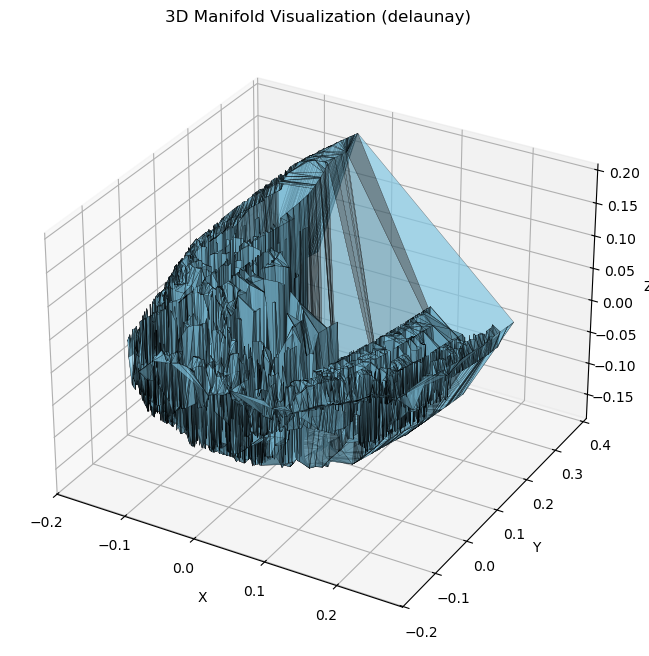

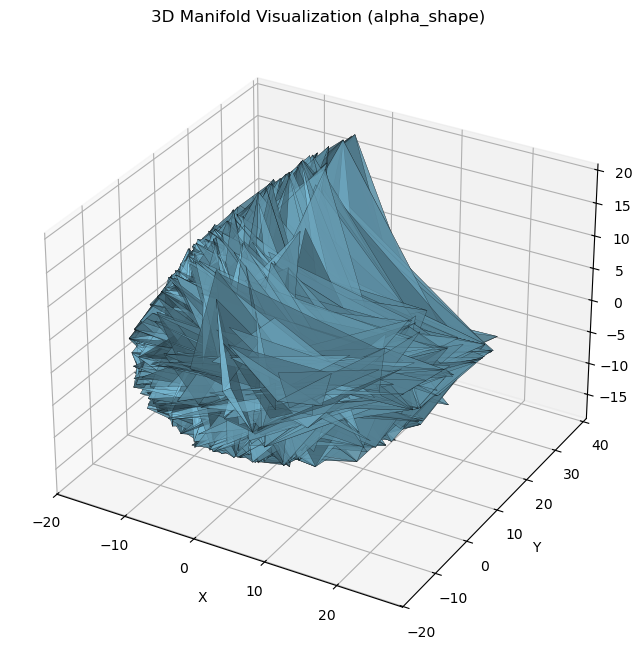

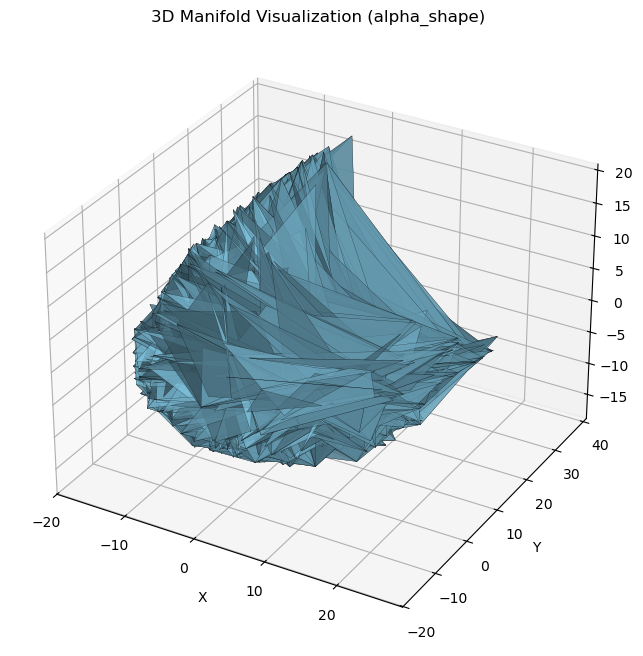

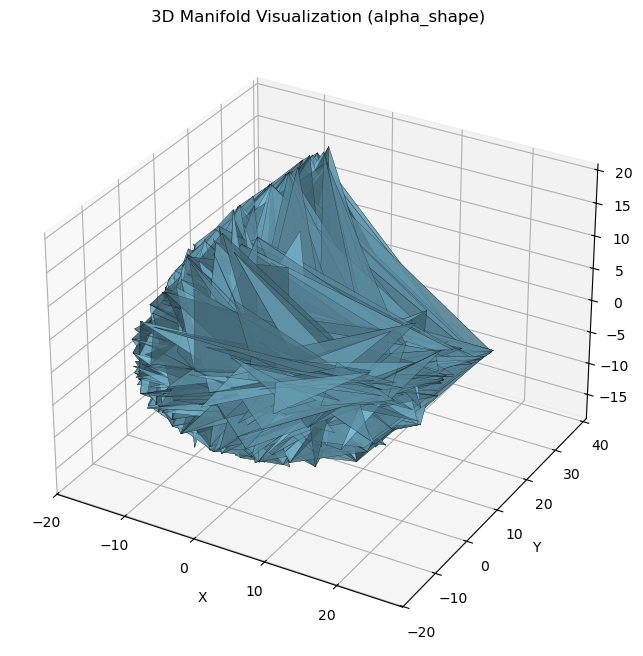

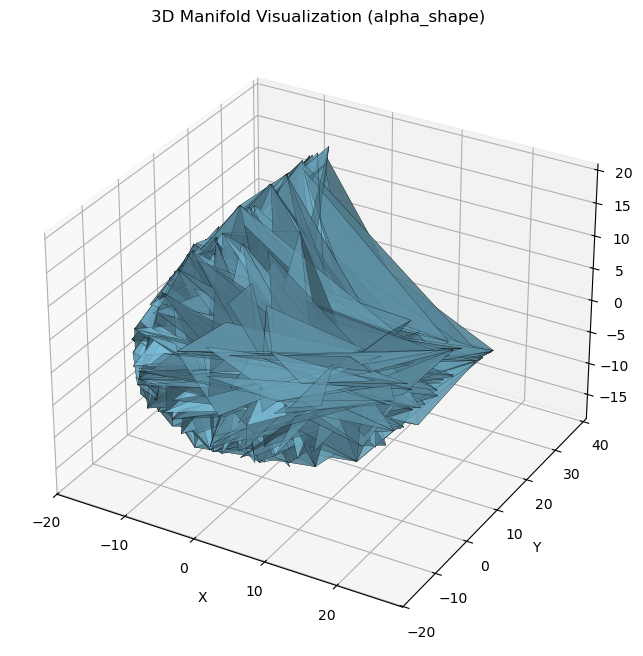

In [9]:
# Ball Pivoting Algorithm (Simplified Implementation)
def ball_pivoting_algorithm(points, ball_radius):
    if RigidRegistration is None:
        print("RigidRegistration is required for Ball Pivoting. Please install pycpd")
        return None

    from sklearn.neighbors import NearestNeighbors
    knn = NearestNeighbors(n_neighbors=10)  # Adjust n_neighbors as needed
    knn.fit(points)
    distances, indices = knn.kneighbors(points)

    triangles = []
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            if np.linalg.norm(points[i] - points[j]) <= 2 * ball_radius:
                for k in range(j + 1, len(points)):
                    if np.linalg.norm(points[j] - points[k]) <= 2 * ball_radius and np.linalg.norm(points[i] - points[k]) <= 2 * ball_radius:
                        triangles.append([i, j, k])
    return np.array(triangles)


def visualize_manifold_from_numpy(points, method="delaunay", alpha_shape_alpha=None, ball_radius=None):
    """Visualizes a 3D manifold with different methods. Corrected for alphashape changes.

    Args:
        points: NumPy array of shape (n_points, 3).
        method: "delaunay", "alpha_shape", or "ball_pivoting".
        alpha_shape_alpha: Alpha value for alpha shape (if applicable).
        ball_radius: Ball radius for ball pivoting (if applicable).
    """

    if points.shape[0] < 4:
        print("Not enough points to form a 3D triangulation.")
        return

    try:
        if method == "delaunay":
            tri = Delaunay(points)
            triangles = tri.simplices
        elif method == "alpha_shape":
            if alphashape is None or alpha_shape_alpha is None:
                print("alphashape library and alpha value are required for alpha shape method.")
                return

            alpha_shape = alphashape(points, alpha_shape_alpha)

            try: #Try 3D, if it fails try 2D
                triangles = np.array(alpha_shape.faces) #3D Case
            except AttributeError:
                triangles = np.array([v for f in alpha_shape.faces for v in f]).reshape(-1, 3) # 2D case
        elif method == "ball_pivoting":
            if ball_radius is None:
                print("Ball radius is required for ball pivoting method.")
                return
            triangles = ball_pivoting_algorithm(points, ball_radius)
            if triangles is None:
                return
        else:
            print("Invalid method specified.")
            return

        if triangles is None or len(triangles) == 0:
            print("No triangles generated. Check parameters or point cloud data.")
            return

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles=triangles, color='skyblue', alpha=0.7, edgecolor='k', linewidth=0.2)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f"3D Manifold Visualization ({method})")

        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")



visualize_manifold_from_numpy(embeddings, method="delaunay")

# Example 2: Alpha Shape (adjust alpha value as needed)
visualize_manifold_from_numpy(100*embeddings, method="alpha_shape", alpha_shape_alpha=0.03)
visualize_manifold_from_numpy(100*embeddings, method="alpha_shape", alpha_shape_alpha=0.02)
visualize_manifold_from_numpy(100*embeddings, method="alpha_shape", alpha_shape_alpha=0.01)
visualize_manifold_from_numpy(100*embeddings, method="alpha_shape", alpha_shape_alpha=0.005)